In [1]:
import pandas as pd
import main

In [2]:
real_top = pd.read_csv('real_data_test\\top_df.csv', delimiter=';')
real_top = real_top.rename(columns={'WELL_NAME': 'WELL_NAME_UWI'})
del real_top['X']
del real_top['Y']
real_top['WELL_NAME_UWI'] = real_top['WELL_NAME_UWI'].astype('str')
real_top.head(n=2)

,WELL_NAME_UWI,DEPTH_TOP
0,100,2548.81
1,101,2556.23


In [3]:
real_bottom = pd.read_csv('real_data_test\\bottom_df.csv', delimiter=';')
real_bottom = real_bottom.rename(columns={'WELL_NAME': 'WELL_NAME_UWI'})
del real_bottom['X']
del real_bottom['Y']
real_bottom['WELL_NAME_UWI'] = real_bottom['WELL_NAME_UWI'].astype('str')
real_bottom.head(n=2)

,WELL_NAME_UWI,DEPTH_BOTTOM
0,100,2564.81
1,101,2571.71


In [4]:
# данные от организаторов
water_content_data = pd.read_csv(main.data_dir + "\\water_content.csv", delimiter=';')
water_content_data = water_content_data.rename(columns={'Скважина': main.keys_dict[main.kid_well]})
water_content_data = water_content_data.rename(columns={' Начальная обводненность ': 'WC'})
water_content_data = water_content_data.rename(columns={'Дата запуска': 'date_start'})
del water_content_data['date_start']
water_content_data = water_content_data.rename(columns={'well_name': 'WELL_NAME'})
water_content_data.head(n=5)
water_content_data['WELL_NAME'] = water_content_data['WELL_NAME'].astype('str')
water_content_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 2 columns):
WELL_NAME    181 non-null object
WC           181 non-null float64
dtypes: float64(1), object(1)
memory usage: 2.9+ KB


In [5]:
print(len(water_content_data['WELL_NAME'].value_counts()))

180


In [6]:
las_out_file_name = 'AllGisParams\\fake_gis_las_all_out.csv'
global_data = pd.read_csv(las_out_file_name, delimiter=';')
global_data['WELL_NAME'] = global_data['WELL_NAME'].astype('str')
global_data['WELL_NAME_UWI'] = global_data['WELL_NAME_UWI'].astype('str')

In [7]:
#params_name = ['KINT', 'R05', 'R20', 'R14', 'R10', 'F07', 'F10', 'F14', 'R07', 'F20', 'F05', 'PHIT', 'MRES', 'SG', 'KGL', 'SXWB', 'GZ3', 'NPHI', 'GZ2', 'GZ4', 'GZ1', 'CILD', 'PROX', 'LLD', 'GZ7', 'APS', 'KPS', 'GZ5']
#params_name = ['CILD', 'GZ7', 'KINT']
#params_name = ['KINT', 'R05', 'R20', 'R14', 'R10', 'F07', 'F10', 'F14', 'R07', 'F20', 'F05', 'PHIT', 'MRES', 'SG', 'KGL', 'SXWB', 'GZ3', 'NPHI', 'GZ2', 'GZ4', 'GZ1', 'CILD', 'PROX', 'LLD', 'GZ7', 'GR:2', 'GR:1', 'APS', 'KPS', 'GZ5', 'SP:1', 'SP:2', 'W:1', 'W:2', 'NKTM:2', 'NKTM:1', 'CFTC:1', 'CFTC:2', 'MLM:2', 'MLM:1', 'RT:1', 'RT:2', 'GR:3']
#params_name = ['R05', 'R14']
params_name = ['KINT']

In [ ]:
#param = 'KINT'
# las_data = global_data[['WELL_NAME', 'WELL_NAME_UWI', 'DEPT', param]].copy()
# las_data['WELL_NAME'] = las_data['WELL_NAME'].astype('str')
# las_data['WELL_NAME_UWI'] = las_data['WELL_NAME_UWI'].astype('str')
# las_data = las_data.dropna()

In [8]:
# объединение данных по всем параметрам
min_count_val_in_data = 10
count_val = 100


# Загружаем данные по параметру
# las_gis_file_name = 'AllGisParams\\fake_gis_las_' + param_name_file +  '_out.csv'
# las_data = pd.read_csv(las_gis_file_name, delimiter=';', low_memory=False)
print('Start union table')
all_params = ['WELL_NAME', 'WELL_NAME_UWI', 'DEPT']
all_params.extend(params_name)
las_data = global_data[all_params].copy()
las_data['WELL_NAME'] = las_data['WELL_NAME'].astype('str')
las_data['WELL_NAME_UWI'] = las_data['WELL_NAME_UWI'].astype('str')
las_data.head(n=5)

# Объединяем данные
real_data = pd.merge(water_content_data, las_data, on='WELL_NAME')
real_data = pd.merge(real_data, real_top, on='WELL_NAME_UWI')
real_data = pd.merge(real_data, real_bottom, on='WELL_NAME_UWI')
real_data_na = real_data.dropna()
print(len(real_data['WELL_NAME'].value_counts()))

# Преобразуем в данные для обучения
dev_path = "..\\tasks\\task 6\\data\\dev\\"
well_name_list = real_data_na['WELL_NAME_UWI'].value_counts().index.tolist()

x_values = []
for param in params_name:
    params_name_file = (param.replace(':','')).lower()
    print('Convert ', param, 'start')

#     [x_values_temp, y_values, y_names] = main.ConvertDataToLearningByStdParams(real_data_na, param, dev_path,
#                                                            min_count_val_in_data)
    [x_values_temp, y_values, y_names, top_values, bottom_values] = main.ConvertDataToLearning(real_data_na, param, dev_path,
                                                               min_count_val_in_data, count_val)
    if (len(x_values) > 0):
        for src, res in zip(x_values_temp, x_values):
            res.extend(src)
            #print('res = ',len(res), 'src = ', len(src))
    else:
        x_values = x_values_temp.copy()
                
    print('length =', len(x_values), len(y_values), len(x_values[0]))
    


# # обучаем дерево
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV, cross_val_score

# forest = RandomForestRegressor(n_estimators=10, n_jobs=---1, random_state=17) # n_jobs=-1
# # print(np.mean(cross_val_score(forest, x_hold, y_hold, cv=6))) # 0.949


# forest_params = { 
#     'max_depth': [1, 10, 20, 40, 60],
#     'n_estimators': [1, 10, 30, 50, 100, 200, 500],
#     'max_features': ['auto', 'sqrt', 'log2']
# }

# print('Start', param, ' learning')
# forest_grid = GridSearchCV(forest, forest_params, cv=5, n_jobs=-1, verbose=True)
# forest_grid.fit(x_train, y_train) 
# print('Convert all_params end')
# print(len(x_values))

Start union table
157
Convert  KINT start
0  of  154
20  of  154
40  of  154
60  of  154
80  of  154
100  of  154
120  of  154
140  of  154
end ConvertDataToLearning
length = 151 151 100


In [ ]:
# построение гистограмы входных данных
import matplotlib.pyplot as plt
# построение графиков

frame_tr = pd.DataFrame(y_hold, columns = ['wc'])
plt_tr = frame['wc'].plot.hist()
plt_tr.figure

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

def data_analize_func(predict_for_analize, file_name = ''):
    # подготовка данных
    data_for_analize = predict_for_analize.sort_values(by=['y_hold'])
    data_for_analize['x_axis'] = [x for x in range(len(predict_for_analize['y_hold']))]
    data_for_analize.head()
    if file_name != '':
        data_for_analize.to_csv('AllGisParams/' + file_name, index=False, sep = ';')
    
    # построение графиков
    plt.scatter(data_for_analize['x_axis'], data_for_analize['y_predict'], color = 'blue')
    plt.scatter(data_for_analize['x_axis'], data_for_analize['y_hold'], color = 'red')
    plt.show()
    
    # regression metrics
    print('MSE                      = '+ str(mean_squared_error(data_for_analize['y_hold'], 
                                                                data_for_analize['y_predict'])))
    print('MAE                      = '+ str(mean_absolute_error(data_for_analize['y_hold'], 
                                                                 data_for_analize['y_predict'])))
    print('r2_score                 = '+ str(r2_score(data_for_analize['y_hold'], 
                                                      data_for_analize['y_predict'])) + '    (best_value is 1)')
    print('explained_variance_score = '+ str(explained_variance_score(data_for_analize['y_hold'], 
                                                                      data_for_analize['y_predict'])) + '    (best_value is 1)')

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score

y_values_r = y_values
x_train, x_hold, y_train, y_hold = train_test_split(x_values, y_values_r, test_size=0.3, random_state=17)

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

forest_reg =  RandomForestRegressor(n_estimators=10,
                           random_state=17)
# oob_score=True,

from sklearn.model_selection import GridSearchCV, cross_val_score
forest_params = { 
    'max_depth': [1, 10, 20, 40, 60, 100, 200, 500],
    'n_estimators': [1, 10, 30, 50, 70, 100, 150, 300],
    'max_features': ['auto', 'sqrt', 'log2']
}
forest_grid = GridSearchCV(forest_reg, forest_params, cv=5, n_jobs=-1, verbose=True)
value_fit = forest_grid.fit(x_train, y_train) 
y_predict = forest_grid.predict(x_hold)

D:\libs\Anaconda\3.3\envs\aind\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  1.0min finished


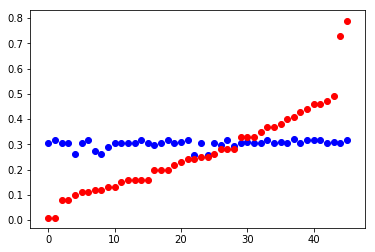

MSE                      = 0.0267635719588
MAE                      = 0.130813884989
r2_score                 = 0.00648897110075    (best_value is 1)
explained_variance_score = 0.0458269676067    (best_value is 1)


In [11]:
predict_for_analize_fake = pd.DataFrame({'y_hold':y_hold, 'y_predict':y_predict})
data_analize_func(predict_for_analize_fake)
#predict_for_analize_fake.to_csv('AllGisParams/result_predict_sum.csv',index=False, sep = ';')

345


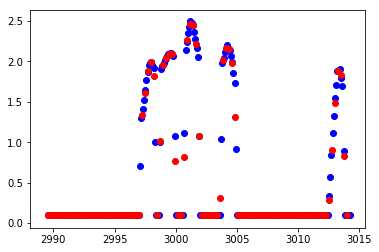

In [58]:
well_i = 110
print(y_names[well_i])
bottom = bottom_values[well_i]
top = top_values[well_i]
data_well = real_data_na[real_data_na['WELL_NAME'] == y_names[well_i]]
data_well_by_bound = data_well[(data_well['DEPT'] >= top) & (data_well['DEPT'] <= bottom)]
x_real = data_well_by_bound['KINT'].tolist()
y_real = data_well_by_bound['DEPT'].tolist()
h_start = data_well_by_bound['DEPT'].min()
h_end = data_well_by_bound['DEPT'].max()
h_step = (h_end - h_start) / count_val
x_values_h = []
i = 0
while (i < count_val):
    x_values_h.append(h_start + i * h_step)
    i = i + 1
# построение графиков
plt.scatter(y_real, x_real, color = 'blue')
plt.scatter(x_values_h, x_values[well_i], color = 'red')
plt.show()

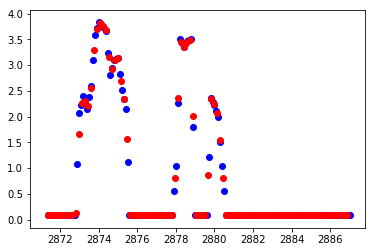

In [ ]:
data_well_by_bound

In [ ]:
# проверка по каждому параметру
params_name = ['KINT', 'R05', 'R20', 'R14', 'R10', 'F07', 'F10', 'F14', 'R07', 'F20', 'F05', 'PHIT', 'MRES', 'SG', 'KGL', 'SXWB', 'GZ3', 'NPHI', 'GZ2', 'GZ4', 'GZ1', 'CILD', 'PROX', 'LLD', 'GZ7', 'APS', 'KPS', 'GZ5']
#params_name = ['R10']
result_mse = {}.fromkeys(params_name, 0)
result_mae= {}.fromkeys(params_name, 0)
result_r2 = {}.fromkeys(params_name, 0)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
count_val = 500
min_count_val_in_data = 10
for param in params_name:
    print('Convert ', param, 'start')
    param_name_file = (param.replace(':','')).lower()
    # Загружаем данные по параметру
    # las_gis_file_name = 'AllGisParams\\fake_gis_las_' + param_name_file +  '_out.csv'
    # las_data = pd.read_csv(las_gis_file_name, delimiter=';', low_memory=False)
    las_data = global_data[['WELL_NAME', 'WELL_NAME_UWI', 'DEPT', param]].copy()
    las_data['WELL_NAME'] = las_data['WELL_NAME'].astype('str')
    las_data['WELL_NAME_UWI'] = las_data['WELL_NAME_UWI'].astype('str')
    las_data.head(n=5)
    
    # Объединяем данные
    real_data = pd.merge(water_content_data, las_data, on='WELL_NAME')
    real_data = pd.merge(real_data, real_top, on='WELL_NAME_UWI')
    real_data = pd.merge(real_data, real_bottom, on='WELL_NAME_UWI')
    real_data_na = real_data.dropna()
    print(len(real_data['WELL_NAME'].value_counts()))
    
    if (param == 'CILD'):
        real_data_na = real_data_na[real_data_na[param] > 0] 
    
    # Преобразуем в данные для обучения
    dev_path = "..\\tasks\\task 6\\data\\dev\\"
    well_name_list = real_data_na['WELL_NAME_UWI'].value_counts().index.tolist()
#     [x_values, y_values, y_names] = main.ConvertDataToLearningStatParamsWithDiff(real_data_na, param, dev_path,
#                                                                min_count_val_in_data, count_val)
#     [x_values, y_values, y_names] = main.ConvertDataToLearningByStdParams(real_data_na, param, dev_path,
#                                                                           min_count_val_in_data)
    [x_values, y_values, y_names] = main.ConvertDataToLearningByStdParams(real_data_na, param, dev_path, min_count_val_in_data)
    
    # y_values_r = [int(10 * y_val) for y_val in y_values]
    y_values_r = y_values
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.model_selection import train_test_split, StratifiedKFold
    from sklearn.metrics import accuracy_score
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.cross_validation import cross_val_score

    x_train, x_hold, y_train, y_hold = train_test_split(x_values, y_values_r, test_size=0.3, random_state=17)
    # обучаем дерево
    # from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import RandomForestRegressor
    
    from sklearn.model_selection import GridSearchCV, cross_val_score
    forest = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=17)
    forest_params = { 
        # 'max_depth': [1, 2, 3, 5, 10, 20, 40, 60],
        'max_depth': [1, 2, 3, 5, 7, 10],
        'n_estimators': [1, 10, 30, 50, 100, 200, 500],
        'max_features': ['auto', 'sqrt', 'log2']
    }
    print('Start', param, ' learning')
    from sklearn.model_selection import LeaveOneOut
    #loo = LeaveOneOut()
    forest_grid = GridSearchCV(forest, forest_params, cv=5, n_jobs=-1, verbose=True)
    forest_grid.fit(x_train, y_train) 
     #result_fit = accuracy_score(y_hold, forest_grid.predict(x_hold))
    print('best_params', forest_grid.best_params_)
    y_predict = forest_grid.predict(x_hold) 
    
#     from sklearn.ensemble import GradientBoostingRegressor
#     boost = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, 
#                                            max_depth=2, random_state=17, loss='ls')
#     boost.fit(x_train, y_train)
#     y_predict = boost.predict(x_hold) 
    # print(np.mean(cross_val_score(forest, x_hold, y_hold, cv=6))) # 0.949
    
   
    mse = mean_squared_error(y_hold, y_predict)
    mae = mean_absolute_error(y_hold, y_predict)
    # r2_score =  r2_score(y_hold, y_predict)

    result_mse[param] = mse
    result_mae[param] = mae
    #result_r2[param] = r2_score
    print('result_mae = ', 100. * mae)
    print('Convert', param, 'end')
print('End calculate, l_values_len = ', len(x_values))

In [ ]:
predict_for_analize_fake = pd.DataFrame({'y_hold':y_hold, 'y_predict':y_predict})
data_analize_func(predict_for_analize_fake)
#predict_for_analize_fake.to_csv('AllGisParams/result_predict_sum_r05.csv',index=False, sep = ';')

In [ ]:
predict_for_analize_mae = pd.DataFrame(list(result_mae.items()), columns=['Param', 'Mae'])
predict_for_analize_mae.to_csv('AllGisParams/result_mae_diff(std_param).csv',index=False, sep = ';')
predict_for_analize_mse = pd.DataFrame(list(result_mse.items()), columns=['Param', 'Mse'])
predict_for_analize_mse.to_csv('AllGisParams/result_mse_diff(std_param).csv',index=False, sep = ';')

In [ ]:
#result_learning.items()
result_data = pd.DataFrame(list(result_learning.items()), columns=['Param', 'Result'])

In [ ]:
result_data.to_csv('AllGisParams/result_learning_std.csv',index=False, sep = ';')

In [ ]:
# Создаем DataFrame
# x_names = ['idx' + str(i) for i in range(len(x_values[0]))]
# data_x_values = pd.DataFrame(x_values, columns = x_names)
# data_y_values = pd.DataFrame(y_values, columns=['wc'])
# data_names = pd.DataFrame(y_names, columns=['WELL_NAME'])
# len(data_x_values)
# data_values = pd.merge(data_y_values, data_names, left_index=True, right_index=True)
# data_values = pd.merge(data_values, data_x_values, left_index=True, right_index=True)

In [ ]:
data_values.head()